In [1]:
import numpy as np
import pandas as pd

import sklearn.model_selection
from sklearn.metrics import log_loss

from sklearn.ensemble import RandomForestClassifier
from supervised.automl import AutoML

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pplonski/datasets-for-start/master/adult/data.csv', skipinitialspace=True)
x_cols = [c for c in df.columns if c != 'income']
X = df[x_cols]
y = df['income']

In [3]:
seed = 1234
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state=seed)


In [4]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
29700,37,Private,34146,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,68,United-States
1529,37,Private,26898,HS-grad,9,Divorced,Exec-managerial,Unmarried,White,Female,0,0,12,United-States
27477,26,Private,190762,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,18,United-States
31950,35,Private,189092,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
4732,23,Private,260019,7th-8th,4,Never-married,Farming-fishing,Unmarried,Other,Male,0,0,36,Mexico


In [5]:
rf = RandomForestClassifier(n_estimators = 1000)
rf = rf.fit(X_train, y_train)

ValueError: could not convert string to float: 'Private'

In [6]:
# The Random Forest does not work with categorical
# Let's convert them, with integer encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

for column in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country']:
    categorical_convert = LabelEncoder()
    X_train[column] = categorical_convert.fit_transform(X_train[column])
    X_test[column] = categorical_convert.transform(X_test[column])

TypeError: '<' not supported between instances of 'float' and 'str'

In [8]:
# still something ?
# looks like we have missing values in the data

In [9]:
X_train[column].head(10)

29700    Private
1529     Private
27477    Private
31950    Private
4732     Private
10858    Private
24518    Private
10035        NaN
1324     Private
26727    Private
Name: workclass, dtype: object

In [10]:
# lets fill with mean values

In [11]:
train_mode = X_train.mode().iloc[0]
X_train = X_train.fillna(train_mode)
X_test = X_test.fillna(train_mode)

In [12]:
# try to fit again

In [13]:
rf = RandomForestClassifier(n_estimators = 1000)
rf = rf.fit(X_train, y_train)

ValueError: could not convert string to float: 'Private'

In [14]:
# oh, yes! still need to convert!

In [15]:
from sklearn.preprocessing import LabelEncoder

for column in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country']:
    categorical_convert = LabelEncoder()
    X_train[column] = categorical_convert.fit_transform(X_train[column])
    X_test[column] = categorical_convert.transform(X_test[column])

ValueError: y contains previously unseen labels: 'Holand-Netherlands'

In [16]:
# what!?@^%$^%$^ ????????
# looks like that there are different labels between X_train and X_test ...
# which can happen in real life as well :) and will break your production model!
# what to do in this situation ?

In [17]:
# we need to assign a new integer for this new label or remove this row from predictions
# let's hack it ...

In [18]:

column = 'native-country'
all_values = np.unique(list(X_test[column].values))
diff = np.setdiff1d(all_values, categorical_convert.classes_)
categorical_convert.classes_ = np.concatenate((categorical_convert.classes_, diff))
X_test[column] = categorical_convert.transform(X_test[column])

In [19]:
np.unique(X_train[column])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [20]:
np.unique(X_test[column])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

In [21]:
# can we train now?

In [22]:
rf = RandomForestClassifier(n_estimators = 1000)
rf = rf.fit(X_train, y_train)

In [23]:
# :), let's do predictions! and compute some metrics!

In [24]:
log_loss(y_test, rf.predict_proba(X_test)[:,1])

0.338857591429531

In [25]:
# Please remember that for production you need to save:
# 1. values used for missing values inputation
# 2. encoders to properly convert categoricals to integers

In [26]:
# and the AutoML way

In [27]:
# let's reread the data, to have raw data

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/pplonski/datasets-for-start/master/adult/data.csv', skipinitialspace=True)
x_cols = [c for c in df.columns if c != 'income']
X = df[x_cols]
y = df['income']
seed = 1234
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state=seed)

In [29]:
automl = AutoML(total_time_limit=60, algorithms=["RF"], train_ensemble=False)
automl.fit(X_train, y_train)

Learner RF final loss 0.31295985228245726 time 3.15 seconds
Learner RF final loss 0.3058324469987815 time 3.05 seconds
Learner RF final loss 0.3065861813563275 time 3.16 seconds
Learner RF final loss 0.305368676349097 time 3.2 seconds
Learner RF final loss 0.3094612291478825 time 3.16 seconds
Learner RF final loss 0.31307862961403815 time 3.17 seconds
Learner RF final loss 0.3056438384380418 time 3.28 seconds
Learner RF final loss 0.5094367132563837 time 3.3 seconds
Learner RF final loss 0.30783368905879144 time 3.15 seconds
Learner RF final loss 0.33719065961498546 time 3.26 seconds
Learner RF final loss 0.3072727392839799 time 3.19 seconds
Learner RF final loss 0.30193530622863163 time 3.21 seconds
Learner RF final loss 0.3078442875513561 time 3.05 seconds
Learner RF final loss 0.308193037515502 time 3.07 seconds
Learner RF final loss 0.3058324469987815 time 3.15 seconds
Learner RF final loss 0.3058324469987815 time 3.11 seconds



In [30]:
log_loss(y_test, automl.predict(X_test)['p_>50K'])

0.3148709233696557

In [31]:
automl.get_leaderboard()

,uid,model_type,metric_type,metric_value,train_time
0,6bfa0d57-01c4-40d7-975a-374ec3b94f4d,RF,logloss,0.312960,3.149549
1,53edf435-bb04-4803-ba25-32228e433a48,RF,logloss,0.305832,3.045671
2,02ea275c-ebcf-4053-9a77-6336fd520f11,RF,logloss,0.306586,3.158201
3,e4ee51d7-db4e-4d60-ab1e-1129228cb29f,RF,logloss,0.305369,3.198720
4,ca2d8d92-7ca7-48c8-bd4c-ce627d3523cb,RF,logloss,0.309461,3.156306
5,744502ae-c48e-4b64-9341-c0acf05becdb,RF,logloss,0.313079,3.169226
6,0930b97d-e060-4908-bed6-a0f05d908f4e,RF,logloss,0.305644,3.276672
7,6cf5c1fd-b100-45b7-9010-d1a051a2b828,RF,logloss,0.509437,3.300742
8,a1683004-755d-4f35-9701-f07a1917871e,RF,logloss,0.307834,3.153975
9,daf12a37-596d-4339-981d-3bef87daf47a,RF,logloss,0.337191,3.257477


In [32]:
automl.to_json()

{'best_model': {'uid': '5884e228-617a-4a05-b5e5-76cda65f731b',
  'algorithm_short_name': 'RF',
  'framework_file': '5884e228-617a-4a05-b5e5-76cda65f731b.framework',
  'framework_file_path': '/tmp/5884e228-617a-4a05-b5e5-76cda65f731b.framework',
  'preprocessing': [{'missing_values': [{'fill_method': 'na_fill_median',
      'fill_params': {'workclass': 'Private',
       'occupation': 'Prof-specialty',
       'native-country': 'United-States'}}],
    'categorical': [{'convert_method': 'categorical_to_int',
      'convert_params': {'workclass': {'Federal-gov': 0,
        'Local-gov': 1,
        'Never-worked': 2,
        'Private': 3,
        'Self-emp-inc': 4,
        'Self-emp-not-inc': 5,
        'State-gov': 6,
        'Without-pay': 7},
       'education': {'10th': 0,
        '11th': 1,
        '12th': 2,
        '1st-4th': 3,
        '5th-6th': 4,
        '7th-8th': 5,
        '9th': 6,
        'Assoc-acdm': 7,
        'Assoc-voc': 8,
        'Bachelors': 9,
        'Doctorate': 10,

In [33]:
automl._best_model.learners[0].model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=4, verbose=0, warm_start=True)

<BarContainer object of 14 artists>

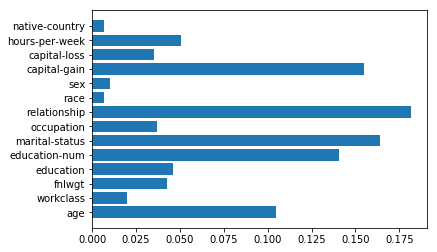

In [35]:
import matplotlib.pyplot as plt
var_imp = automl._best_model.learners[0].model.feature_importances_
plt.barh(X_train.columns, var_imp)